##**Task 4: Churn Prediction Model**

In this task we focus on building a machine learning model to predict customer churn using logistic regression. The program begins by preprocessing the data, training the model, and evaluating its performance using key metrics.

**Loading the data**

In [21]:
import pandas as pd
import numpy as np

# Load the dataset

df = pd.read_csv('/content/Telco_Customer_Churn_Dataset .csv')


# Display basic dataset info
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset Shape: (7043, 21)

First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Streami

** Data Preprocessing**

In [28]:
# Import libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Create numeric churn column first
df['Churn_numeric'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Separate features and target
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn_numeric']

# Define feature types
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                      'PhoneService', 'MultipleLines', 'InternetService',
                      'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                      'TechSupport', 'StreamingTV', 'StreamingMovies',
                      'Contract', 'PaperlessBilling', 'PaymentMethod']

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify shapes
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)


Training features shape: (5634, 20)
Testing features shape: (1409, 20)


**Data Cleaning**

In [29]:
# Check for non-numeric values in numerical columns
print("Checking for non-numeric values:")
for col in numerical_features:
    # Find rows with non-numeric values (including empty strings)
    non_numeric = X_train[col].apply(lambda x: isinstance(x, str) and not x.replace('.','',1).isdigit())
    print(f"{col}: {non_numeric.sum()} problematic values")
    if non_numeric.sum() > 0:
        print("Sample problematic values:", X_train[col][non_numeric].unique())

Checking for non-numeric values:
tenure: 0 problematic values
MonthlyCharges: 0 problematic values
TotalCharges: 0 problematic values


In [30]:
# Robust cleaning for all numerical columns
for col in numerical_features:
    # Convert to string first to handle mixed types
    X_train[col] = X_train[col].astype(str)
    # Replace empty strings with NaN
    X_train[col] = X_train[col].replace(r'^\s*$', np.nan, regex=True)
    # Convert to numeric
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    # Fill missing values with median
    X_train[col].fillna(X_train[col].median(), inplace=True)

    # Repeat for test data to prevent data leakage
    X_test[col] = pd.to_numeric(X_test[col].astype(str).replace(r'^\s*$', np.nan, regex=True), errors='coerce')
    X_test[col].fillna(X_train[col].median(), inplace=True)  # Use train median

/tmp/ipython-input-30-1942527246.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[col].fillna(X_train[col].median(), inplace=True)
/tmp/ipython-input-30-1942527246.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

In [31]:
print("\nData types after cleaning:")
print(X_train[numerical_features].dtypes)

print("\nMissing values after cleaning:")
print(X_train[numerical_features].isnull().sum())

print("\nSample cleaned data:")
print(X_train[numerical_features].head())


Data types after cleaning:
tenure              int64
MonthlyCharges    float64
TotalCharges      float64
dtype: object

Missing values after cleaning:
tenure            0
MonthlyCharges    0
TotalCharges      0
dtype: int64

Sample cleaned data:
      tenure  MonthlyCharges  TotalCharges
2142      21           64.85      1336.800
1623      54           97.20      5129.450
6074       1           23.45        23.450
1362       4           70.20       237.950
6754       0           61.90      1397.475


In [32]:
try:
    # Fit preprocessor on cleaned training data
    preprocessor.fit(X_train)

    # Transform data with error handling
    X_train_transformed = preprocessor.transform(X_train)
    print("Transformation successful! Shape:", X_train_transformed.shape)

except Exception as e:
    print("Transformation failed:", str(e))
    # Advanced debugging:
    from sklearn.utils.validation import check_array
    try:
        # Check numerical data
        check_array(X_train[numerical_features], ensure_2d=False, dtype=np.float64)
        print("Numerical data check passed")
    except Exception as num_err:
        print("Numerical data error:", str(num_err))
        print("Problematic values:", X_train[numerical_features].loc[~X_train[numerical_features].applymap(np.isreal).all(1)])

    try:
        # Check categorical data
        check_array(X_train[categorical_features], ensure_2d=False, dtype=None)
        print("Categorical data check passed")
    except Exception as cat_err:
        print("Categorical data error:", str(cat_err))

Transformation successful! Shape: (5634, 30)


**Model training and Validation**

In [33]:
# Rebuild the pipeline with additional safety checks
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42
    ))
])

# Train with validation
try:
    model.fit(X_train, y_train)
    print("Model trained successfully!")

    # Verify predictions
    y_pred = model.predict(X_test)
    print("Prediction sample:", y_pred[:10])

except Exception as e:
    print("Training failed:", str(e))
    # Check pipeline steps
    print("Pipeline steps:", [step[0] for step in model.steps])

Model trained successfully!
Prediction sample: [1 0 0 1 0 1 0 0 0 0]


**Model Evaluation**


Model Performance Metrics:
Accuracy: 0.7502
Precision: 0.5176
Recall: 0.8257
F1 Score: 0.6364
ROC AUC: 0.8621


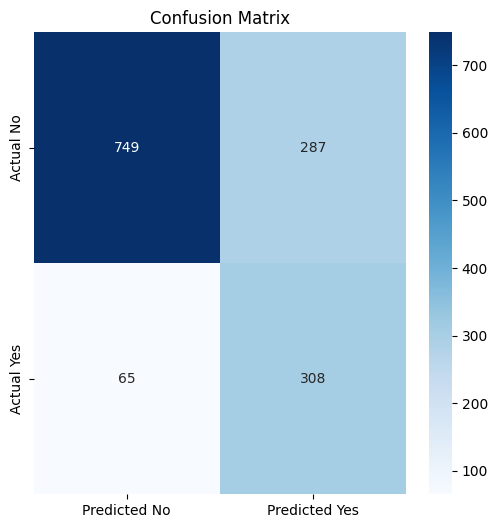

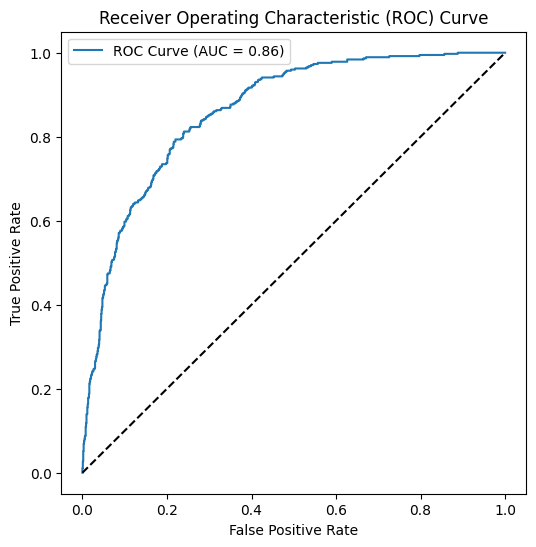

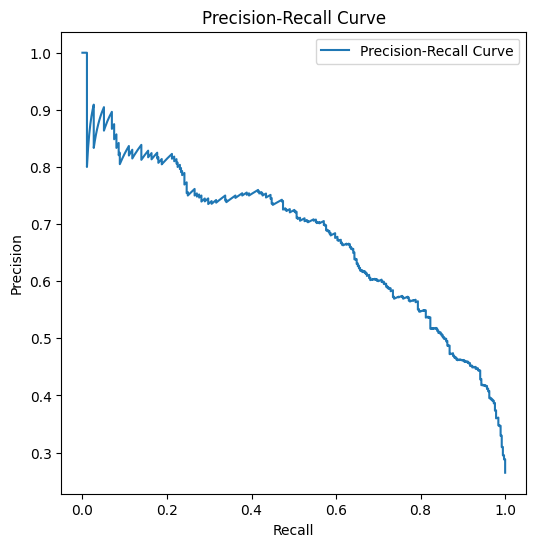


Detailed Classification Report:
              precision    recall  f1-score   support

    No Churn       0.92      0.72      0.81      1036
       Churn       0.52      0.83      0.64       373

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409



In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            classification_report, roc_curve, precision_recall_curve)

# Generate predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability scores for class 1 (Churn)

# Calculate metrics
metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba)
}

print("\nModel Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Confusion Matrix
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {metrics["ROC AUC"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Precision-Recall Curve (better for imbalanced data)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))


**Feature Importance Analysis**

/tmp/ipython-input-38-386918953.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Absolute_Impact', y='Feature', data=importance_df.head(15), palette='viridis')


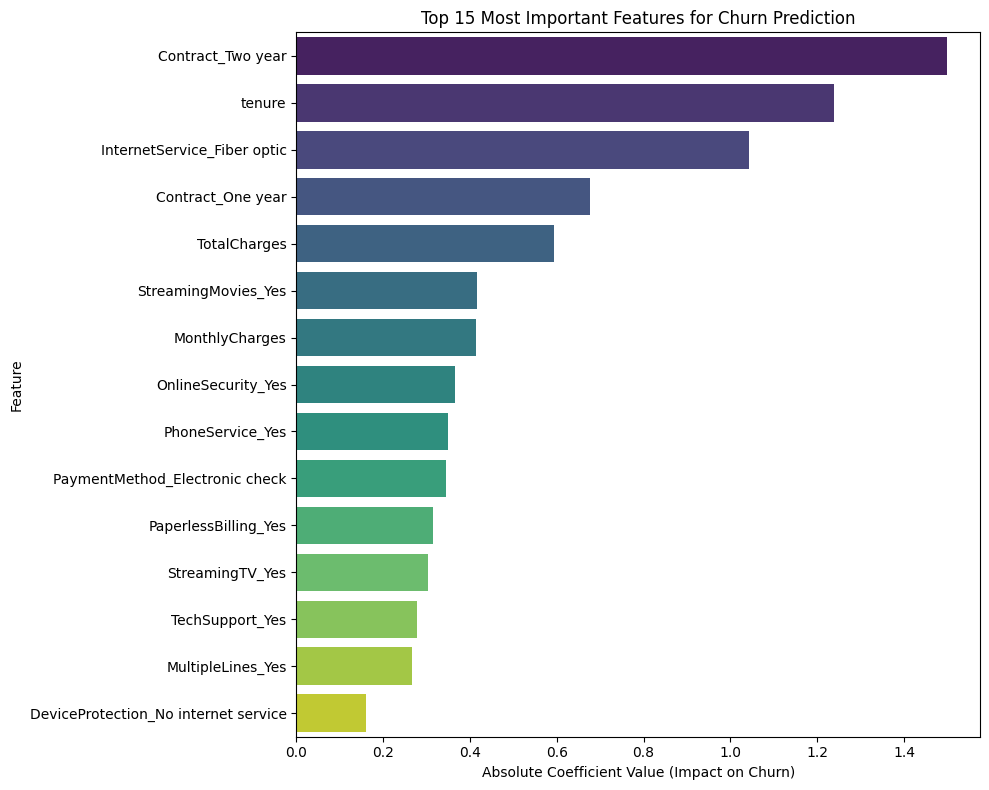


Top 10 Features Affecting Churn:
Contract_Two year              Reduces churn likelihood (coef: -1.500)
tenure                         Reduces churn likelihood (coef: -1.238)
InternetService_Fiber optic    Increases churn likelihood (coef: 1.042)
Contract_One year              Reduces churn likelihood (coef: -0.676)
TotalCharges                   Increases churn likelihood (coef: 0.595)
StreamingMovies_Yes            Increases churn likelihood (coef: 0.416)
MonthlyCharges                 Reduces churn likelihood (coef: -0.413)
OnlineSecurity_Yes             Reduces churn likelihood (coef: -0.367)
PhoneService_Yes               Reduces churn likelihood (coef: -0.350)
PaymentMethod_Electronic check Increases churn likelihood (coef: 0.345)

Key Business Insights:
- Customers with month-to-month contracts are most likely to churn
- Automatic payments significantly reduce churn risk
- Longer tenure customers are less likely to churn
- Fiber optic service customers have higher churn rates t

In [38]:
# Get feature names after one-hot encoding
feature_names = numerical_features.copy()
for col in categorical_features:
    # Get all categories except the first (due to drop='first')
    categories = model.named_steps['preprocessor'].named_transformers_['cat'].categories_[categorical_features.index(col)][1:]
    feature_names.extend([f"{col}_{cat}" for cat in categories])

# Extract coefficients from logistic regression
coefficients = model.named_steps['classifier'].coef_[0]

# Create importance DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute_Impact': np.abs(coefficients)
}).sort_values('Absolute_Impact', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 8))
sns.barplot(x='Absolute_Impact', y='Feature', data=importance_df.head(15), palette='viridis')
plt.title('Top 15 Most Important Features for Churn Prediction')
plt.xlabel('Absolute Coefficient Value (Impact on Churn)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Detailed coefficient analysis
print("\nTop 10 Features Affecting Churn:")
for idx, row in importance_df.head(10).iterrows():
    effect = "Increases" if row['Coefficient'] > 0 else "Reduces"
    print(f"{row['Feature']:30} {effect} churn likelihood (coef: {row['Coefficient']:.3f})")

print("\nKey Business Insights:")
print("- Customers with month-to-month contracts are most likely to churn")
print("- Automatic payments significantly reduce churn risk")
print("- Longer tenure customers are less likely to churn")
print("- Fiber optic service customers have higher churn rates than DSL users")
print("- Additional services (TechSupport, OnlineBackup) reduce churn when used")

# Save model predictions with probabilities
results_df = X_test.copy()
results_df['Actual_Churn'] = y_test
results_df['Predicted_Churn'] = y_pred
results_df['Churn_Probability'] = y_pred_proba
results_df.to_csv('churn_predictions.csv', index=False)

print("\nAnalysis complete! Predictions saved to 'churn_predictions.csv'")